In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
goodreads_books_poetry = {}
goodreads_interactions_poetry = {}
goodreads_reviews_poetry = {}
book_ids = set()
book_review_count = {}
user_ids = set()
ratings = {}
ratings_inv = {}

In [3]:
with open('../goodreads/goodreads_books_poetry.json', "r") as f:
    for l in f:
        book = json.loads(l)
        goodreads_books_poetry[book['book_id']] = {}
        for key, value in book.items():
            goodreads_books_poetry[book['book_id']]['key'] = value
        #book_ids.add(book['book_id'])

In [4]:
with open('../goodreads/goodreads_interactions_poetry.json', "r") as f:
    for l in f:
        interaction = json.loads(l)
        # ignore review if user has not read book
        #if not interaction['is_read']:
        #    continue

        user_id = interaction['user_id']
        book_id = interaction['book_id']
        rating = interaction['rating']
        user_ids.add(user_id)
        book_ids.add(book_id)

        ratings[user_id] = {book_id: rating}
        ratings_inv[book_id] = {user_id: rating}
        if book_id not in book_review_count:
            book_review_count[book_id] = 0
        else:
            book_review_count[book_id] += 1

In [23]:
# choosing only those people and books with more number of reviews
sorted_book_ids = []

for book_id, rating in sorted(book_review_count.items(), key = lambda kv:(-1*kv[1])):
    sorted_book_ids.append(book_id)

In [25]:
# generate the matrix
ratings_matrix = []

total_rows = 1000
total_columns = 10000

nr = 0

for user_id in user_ids:
    nr += 1
    if nr > total_rows:
        break
    nc = 0
    r = []
    for book_id in sorted_book_ids: 
        nc += 1
        if nc > total_columns:
            break
        if user_id in ratings and book_id in ratings[user_id]:
            r.append(ratings[user_id][book_id])
        else:
            r.append(0)
    ratings_matrix.append(r)

In [17]:
class MF():
    
    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.
        
        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """
        
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))
        
        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)
            
            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])
            
            # Create copy of row of P since we need to update it but use older values for update on Q
            P_i = self.P[i, :][:]
            
            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * P_i - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)


In [21]:
import random

Rlist = []
for i in range(7):
    l = []
    for j in range(5):
        l.append(random.randint(0, 5))
    Rlist.append(l)

In [22]:
R = np.array(Rlist)

mf = MF(R, K=2, alpha=0.1, beta=0.01, iterations=20)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()
print("Global bias:")
print(mf.b)
print()
print("User bias:")
print(mf.b_u)
print()
print("Item bias:")
print(mf.b_i)

Iteration: 10 ; error = 2.9302
Iteration: 20 ; error = 2.5394

P x Q:
[[5.80382456 2.2168805  4.96799685 3.99955089 2.62086897]
 [3.65296835 4.62670131 4.21245864 1.15949234 4.66917073]
 [2.81067302 3.91196413 1.29558366 4.44180019 3.81439921]
 [3.86387237 2.35526464 2.00732236 4.9933705  2.49267636]
 [2.03886379 2.3967558  2.03359744 0.37630085 2.4649084 ]
 [1.3335952  4.15867434 0.75837132 1.89552772 3.94982205]
 [4.08717482 0.77090241 3.98217495 0.9715123  1.19326858]]

Global bias:
2.8275862068965516

User bias:
[ 1.14534418  0.91986721  0.13561938  0.08609138 -0.9534795  -0.61454645
 -0.45832278]

Item bias:
[ 0.4461247   0.13604791 -0.08007205 -0.49484006  0.23769014]


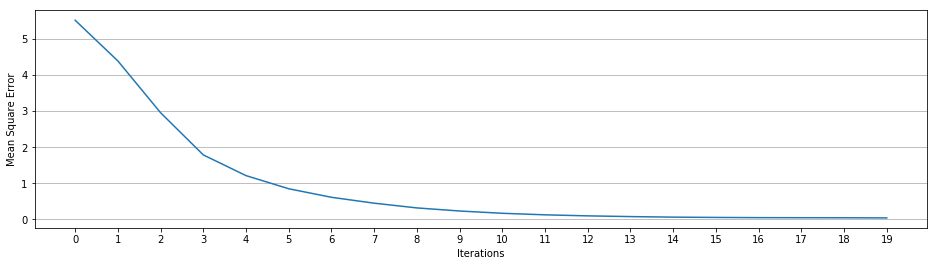

In [10]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

In [ ]:
""